In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
from pathlib import Path

# Data paths
DATA_ROOT = Path("/app/output")
CSV_PATH = DATA_ROOT / "processed_data" / "dataset.csv"

# Labels
LABEL_NAMES = {0: "Pronation", 1: "Neutral", 2: "Supination"}

# Matplotlib configuration
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

In [2]:
# Load and inspect data
df = pd.read_csv(CSV_PATH)
print(f"Dataset loaded. Total samples: {len(df)}")

# Add readable label column
df['label_name'] = df['label'].map(LABEL_NAMES)
display(df.head())

Dataset loaded. Total samples: 323


,filename,label,label_name
0,processed_data/images/B8V41Y_internet_actualne...,0,Pronation
1,processed_data/images/B8V41Y_internet_algeos_0...,1,Neutral
2,processed_data/images/B8V41Y_internet_everypix...,0,Pronation
3,processed_data/images/B8V41Y_internet_facebook...,0,Pronation
4,processed_data/images/B8V41Y_internet_freepic_...,0,Pronation


In [3]:
# Calculate class distribution
counts = df['label_name'].value_counts()

# Enforce logical order
desired_order = ["Pronation", "Neutral", "Supination"]
existing_order = [lbl for lbl in desired_order if lbl in counts.index]
counts = counts[existing_order]

# Define colors mapped to specific labels to ensure consistency
color_map = {"Pronation": '#d9534f', "Neutral": '#5cb85c', "Supination": '#428bca'}
plot_colors = [color_map[lbl] for lbl in counts.index]

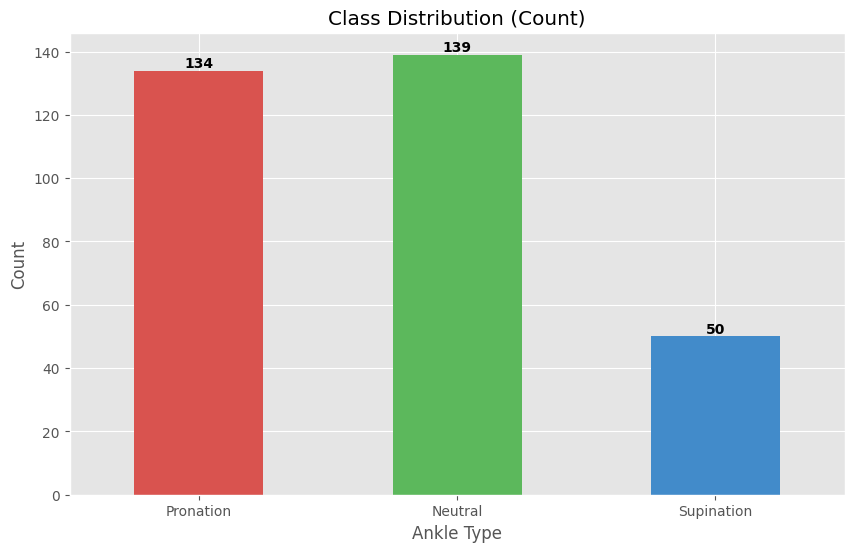

In [4]:
# Bar Chart
plt.figure(figsize=(10, 6))
ax = counts.plot(kind='bar', color=plot_colors, rot=0)
plt.title("Class Distribution (Count)")
plt.xlabel("Ankle Type")
plt.ylabel("Count")

for i, v in enumerate(counts):
    ax.text(i, v + 1, str(v), ha='center', fontweight='bold')
plt.show()

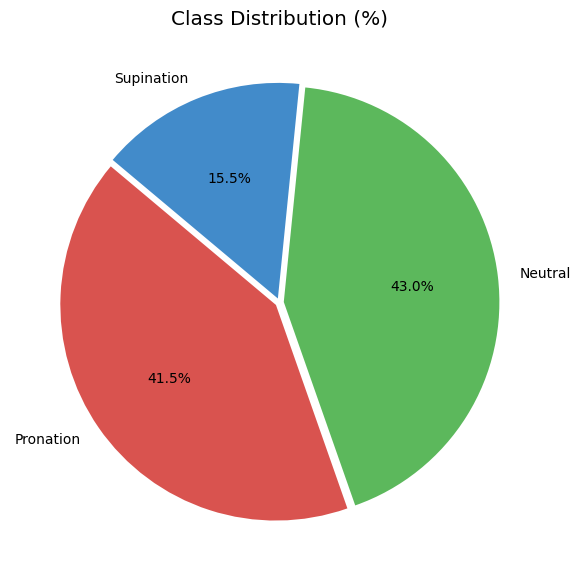

In [5]:
# Pie Chart (Percentages)
plt.figure(figsize=(7, 7))
plt.pie(counts, 
        labels=counts.index, 
        autopct='%1.1f%%', 
        colors=plot_colors, 
        startangle=140, 
        explode=[0.02]*len(counts))

plt.title("Class Distribution (%)")
plt.show()

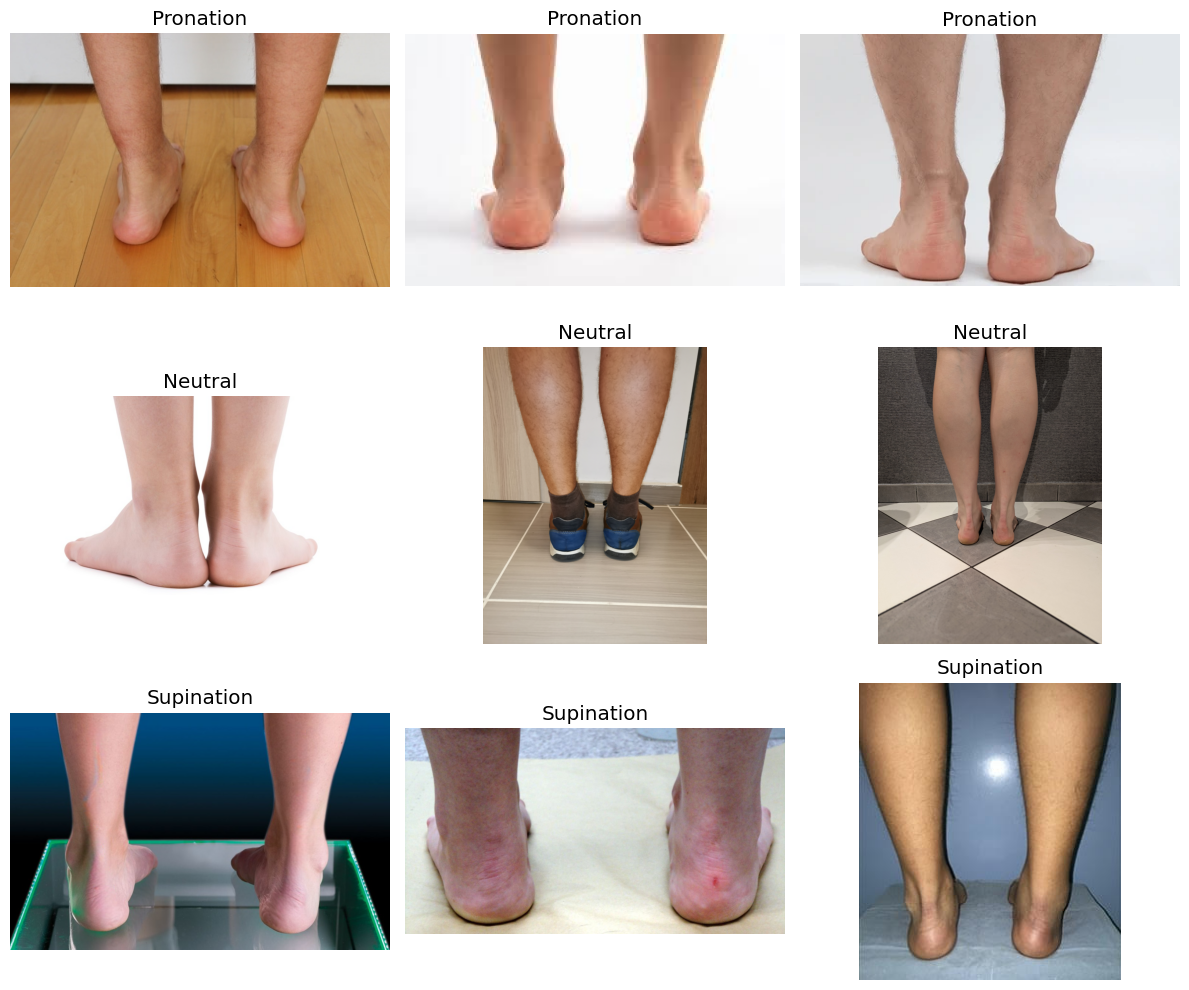

In [6]:
def visualize_samples(df, num_samples=3):
    """Visualize random samples from each class."""
    classes = sorted(df['label'].unique())
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(12, 10))
    
    for i, label_id in enumerate(classes):
        class_df = df[df['label'] == label_id]
        
        if len(class_df) >= num_samples:
            samples = class_df.sample(num_samples)
        else:
            samples = class_df
            
        for j, (_, row) in enumerate(samples.iterrows()):
            if len(classes) > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]
            
            img_path = DATA_ROOT / row['filename']
            
            try:
                img = Image.open(img_path)
                img = ImageOps.exif_transpose(img)
                
                ax.imshow(img)
                ax.set_title(LABEL_NAMES[label_id])
                ax.axis('off')
            except Exception as e:
                ax.text(0.5, 0.5, "ERROR", ha='center')
                print(f"Error loading image: {e}")

    plt.tight_layout()
    plt.show()

visualize_samples(df)

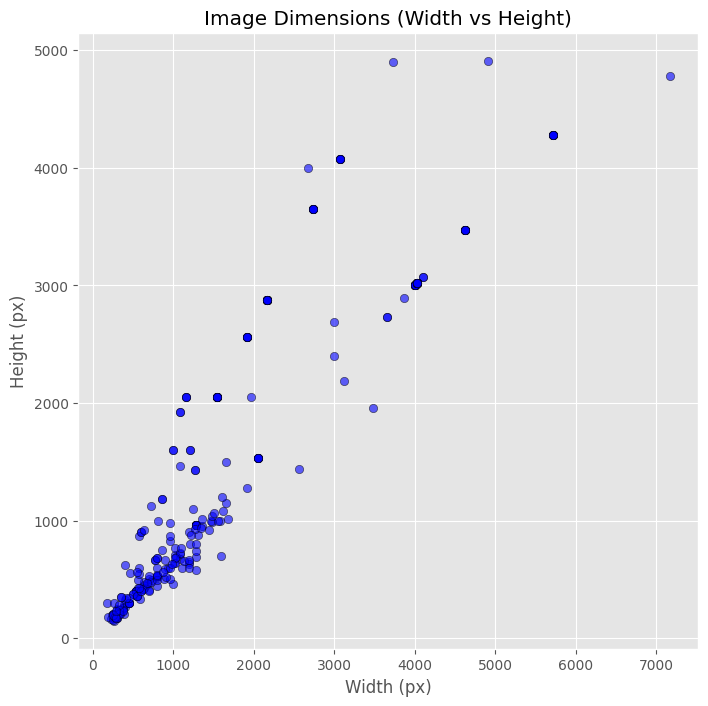

Average size: 1840x1595


In [7]:
# Analyze image dimensions
widths = []
heights = []

# Collect dimensions
for _, row in df.iterrows():
    img_path = DATA_ROOT / row['filename']
    try:
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except:
        pass

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(widths, heights, alpha=0.6, c='blue', edgecolors='k')
plt.title("Image Dimensions (Width vs Height)")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.grid(True)
plt.show()

# Calculate average
if widths:
    avg_w = int(sum(widths)/len(widths))
    avg_h = int(sum(heights)/len(heights))
    print(f"Average size: {avg_w}x{avg_h}")

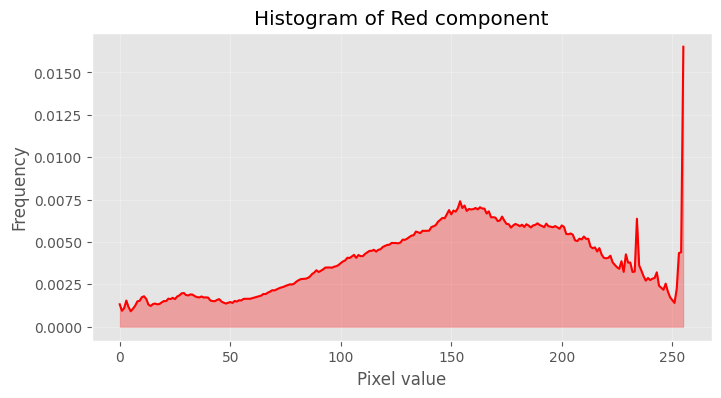

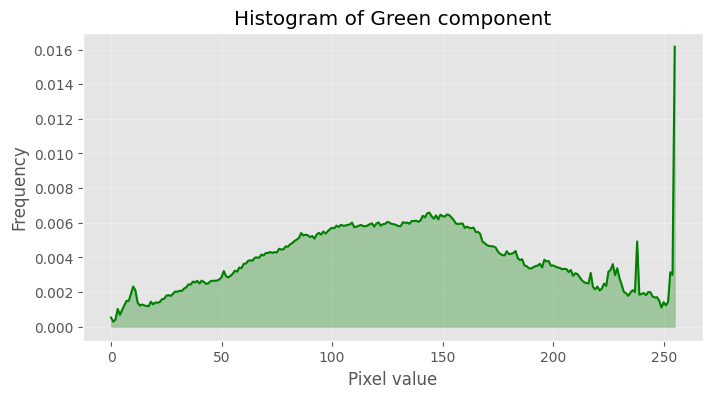

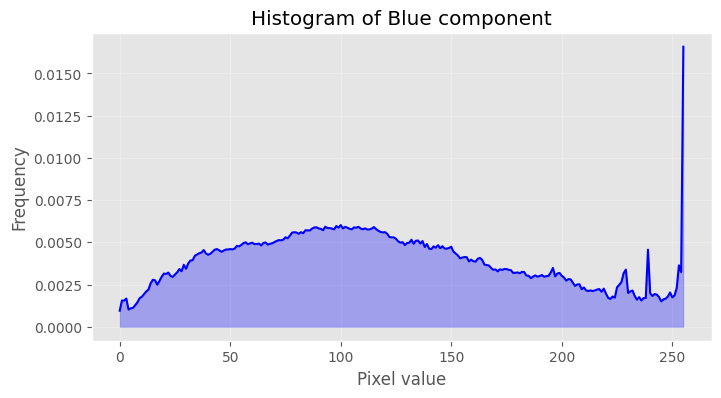

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_color_distributions(df):    
    red_values = []
    green_values = []
    blue_values = []
    
    # Iterate through the sample images to collect pixel data
    for _, row in df.iterrows():
        img_path = DATA_ROOT / row['filename']
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                # Resize to speed up processing (optional, but recommended for loops)
                img = img.resize((64, 64)) 
                arr = np.array(img)
                
                # Accumulate pixel values for each channel
                red_values.extend(arr[:, :, 0].flatten())
                green_values.extend(arr[:, :, 1].flatten())
                blue_values.extend(arr[:, :, 2].flatten())
        except:
            pass

    # Helper function to plot a single channel with the requested style
    def plot_histogram(values, color, title):
        plt.figure(figsize=(8, 4)) # Create a new figure for each channel
        
        # Compute histogram with density=True to normalize the y-axis
        counts, bins = np.histogram(values, bins=256, range=(0, 256), density=True)
        
        # Plot the histogram line
        plt.plot(bins[:-1], counts, color=color)
        # Fill the area under the curve
        plt.fill_between(bins[:-1], counts, color=color, alpha=0.3)
        
        plt.title(f'Histogram of {title} component')
        plt.xlabel('Pixel value')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.show()

    # Plot histogram for the Red channel
    plot_histogram(red_values, 'red', 'Red')

    # Plot histogram for the Green channel
    plot_histogram(green_values, 'green', 'Green')

    # Plot histogram for the Blue channel
    plot_histogram(blue_values, 'blue', 'Blue')

plot_color_distributions(df)

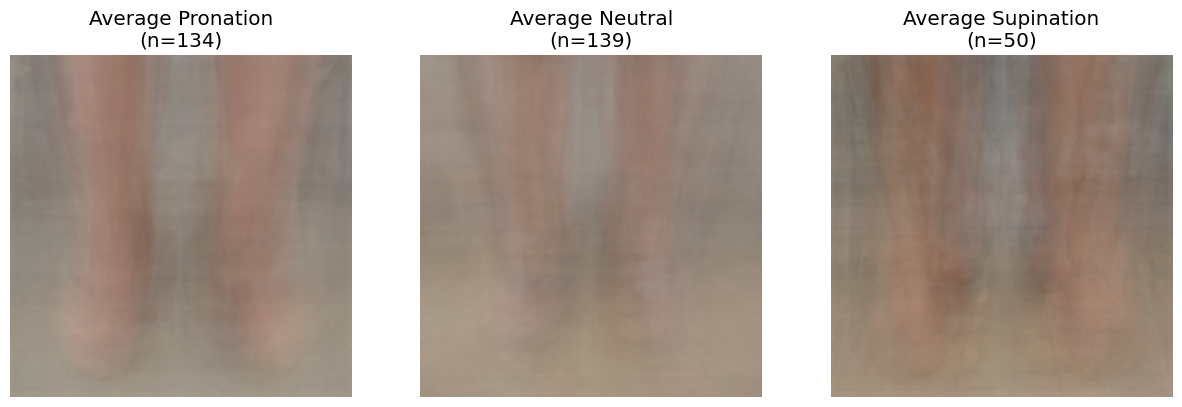

In [9]:
def show_average_images(df):
    classes = sorted(df['label'].unique())
    
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    
    for i, label_id in enumerate(classes):
        class_df = df[df['label'] == label_id]
        
        # Initialize accumulator (float for averaging)
        avg_img_arr = np.zeros((224, 224, 3), dtype=float)
        count = 0
        
        for _, row in class_df.iterrows():
            img_path = DATA_ROOT / row['filename']
            try:
                with Image.open(img_path) as img:
                    img = ImageOps.exif_transpose(img)
                    
                    img = img.convert('RGB').resize((224, 224))
                    avg_img_arr += np.array(img)
                    count += 1
            except:
                pass
        
        if count > 0:
            avg_img_arr /= count
            # Convert back to valid image format (0-255 uint8)
            avg_img_arr = np.clip(avg_img_arr, 0, 255).astype('uint8')
            
            axes[i].imshow(Image.fromarray(avg_img_arr))
            axes[i].set_title(f"Average {LABEL_NAMES[label_id]}\n(n={count})")
            axes[i].axis('off')

    plt.show()

show_average_images(df)